# FIX - Term Frequencies partitioned by gender

In previous notebooks, we have used speakers' genders to apply a gender label to each talk. The gender labels used are: male, female, and not one gender. We note that the list of speakers in the corpus of TED talks identify on the gender binary, at least in the public facing documents about them (which include their TED talk bios and third party websites and publicity). 




## Summary

This is the second attempt to look a freqencies by gender. In the first attempt in `03-Terms-by-gender`, we applied the method from `01-Terms.ipynb` on just the talks gendered as "female." This approach has some limits, chiefly that if we also do the same to "male" talks, we have no clear method for comparing how different words appear in talks by either binary gender. 

In this second attempt, we will instead load the talks such that the male talks are all together, followed by the female talks, and finally followed by those talks that are neither binary gender. 

In this notebook, we will **not** take each subset individually but rather as one partitioned set (first talks labeled male, female, and not one gender) and complete the following procedure: 

### Fix

* Remove the parentheticals
* Create term matrix from the resulting vocabulary
* Adjust the threshold for a word to be included in the term-matrix
* Export the resulting as a CSV 

<div class="alert alert-block alert-success">
<p><b>Parentheticals:</b> Not sure how large an impact this has. Possibly a low priority.</p>
<p><b>Threshold:</b> Included the `min_df = 2` from the Term notebook in this version of the notebook.</p>
</div>


## Load Imports and Data

In [1]:
# IMPORTS

import re, csv, nltk
import numpy as np, pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import NMF
# from nltk.corpus import stopwords

import matplotlib.pyplot as plt

<div class="alert alert-block alert-success">
The code below is to make the figures more readable (for older eyes).
</div>

In [2]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 300

In [3]:
# LOCAL FUNCTION --> Explained in 01-Terms.ipynb

parentheticals = [ "\(laughter\)", "\(applause\)", "\(music\)",  
                  "\(video\)", "\(laughs\)", "\(applause ends\)", 
                  "\(audio\)", "\(singing\)", "\(music ends\)", 
                  "\(cheers\)", "\(cheering\)", "\(recording\)", 
                  "\(beatboxing\)", "\(audience\)", "\(guitar strum\)", 
                  "\(clicks metronome\)", "\(sighs\)", "\(guitar\)", 
                  "\(marimba sounds\)", "\(drum sounds\)" ]

def remove_parentheticals(text):
    global parentheticals
    new_text = text
    for rgx_match in parentheticals:
        new_text = re.sub(rgx_match, ' ', new_text.lower(), 
                          flags=re.IGNORECASE)
    return new_text

In [4]:
# Load data

# Load binary gendered talks 
talks_male = pd.read_csv('talks_male.csv', index_col='Talk_ID')
talks_female = pd.read_csv('talks_female.csv', index_col='Talk_ID')

# No one gender ==> NOG
talks_nog = pd.read_csv('talks_nog.csv', index_col='Talk_ID')

In [5]:
print(talks_male.shape[0], talks_female.shape[0], talks_nog.shape[0])

720 260 12


In [6]:
# Concatenate the data
all_talks = pd.concat([talks_male,talks_female,talks_nog])
all_talks.shape

(992, 14)

In [7]:
# check that the shape is what we expect

print(all_talks.shape[0] == (talks_male.shape[0]+
                             talks_female.shape[0]+talks_nog.shape[0]))
print(all_talks.shape[1] == talks_nog.shape[1])

True
True


## Raw Frequencies
### Rewrite
The goal of this notebook is to establish how we are going to elicit our features, our words, from the collection of talks. Thus, the only column we are interested in is the one with the texts of the talks. While we recognize the utility of having the data in one file, we are looking to minimize individual file sizes, and also make it possible only to load the data we need for any particular task. For that reason, we have chosen to create a number of CSV files, using the ID number that TED assigns each talk as it publishes them to its website.

For this first experiment, we keep it simple by creating two lists, one of the talk IDs and one of the texts themselves: we will only be using the IDs later when we write the DTM to a CSV. This ID will allow us later to correlate the DTM with metadata associated with each talk: the speaker, her biography, the talk's popularity, etc. 

In [8]:
texts = all_talks.text.tolist()

**Nota bene**: If you are using this notebook to re-create the basic TF matrix you can stop here and jump to the end of this notebook.

There are a number of ways to get term frequencies, but **SciKit-Learn**'s `CountVectorizer` offers a one-stop shop for generating a DTM from which we can examine words as well as generate BoW-products like topic models. This is made possible by the interoperability between `CountVectorizer` and the other vectorizers and models available in `sklearn`.



In our first experiment, we run `CountVectorizer` unadorned. The default options are: lowercase everything, get rid of all punctuation, make a word out of anything more than two characters long. The only thing that might not be welcome is the splitting of contractions. For now, we will leave things as they are. (Also, please note, no stopwords were used, so we have an unfiltered word list and no pre-processing of the texts is done.)

### CHECK THIS ASSERTION: 
Since `CountVectorizer` only counts when *fitting* and does not engage in any kind of normalization or centering, *transforming*, there is no need to break the two functionalities out in the code that follows.

<div class="alert alert-block alert-warning">
Did you get an answer for this?
</div>

In [9]:
# If you want to pass options, pass them here:
vectorizer = CountVectorizer(lowercase = True, 
                             min_df = 2
                            )

# fit the model to the data 
# vecs = vectorizer.fit(partitioned_texts)
X = vectorizer.fit_transform(texts)
X.shape

(992, 22433)

<div class="alert alert-block alert-warning">
I dropped most of the experiments here, sticking with the results of the Terms notebook, thus changing to a "min_df = 2" and dropping the "max_df = 0.1" ... which meant we were dropping words that appeared in more than 10 percent of documents? This changes a number of things below.
</div>

39418 tokens is our raw, unfiltered, no pre-processing baseline. It includes, as we will see, a number of artifacts of the TED transcription process, including a variety of ways to spell out *ah*, the use of numerals for a host of things -- from dates to counts and everything in between, and some things which actually take places outside the talk itself, like audience laughter, which we here term *parentheticals*. (Accounting for all these artifacts requires a number of closer inspections, which take place in a separate notebook: [Term Artifacts](Terms-02).)

**Note:** Including `min_df=2` dropped our features almost by half.

In [10]:
raw_df = pd.DataFrame(X.toarray(), 
                      columns = vectorizer.get_feature_names_out())
raw_df.shape

(992, 22433)

In [11]:
word_list = list(raw_df.columns)

len(word_list)

22433

In [12]:
word_list.index("aaa")

411

In [13]:
word_list[410:414]

['aa', 'aaa', 'aaaah', 'aah']

As with the full corpus (`01-Terms.ipynb`), a hand inspection of the output above turned up a couple of interesting issues. Noting that the transcripts for TED talks are largely crowd-sourced, we note a few differences in how "crowd noises" are noted in transcripts: 

With the change in vectorizer parameters, it looks like we lose a lot of the "one-off" crowd noise transcriptions: we now have 4. (The scope of the index above, `410:414` was tightened by hand to display only these results in order to replicate the previous experiment.

<div class="alert alert-block alert-warning">
<p>Crowd noises which were at 782:788 are now 410:414.</p>
<p>The change in indexes has been made throughout the code -- automating this might be worth our while?
</div>

In [14]:
# Get the counts of the different transcribed noises 
# by "gender" of talks

male_crowd = raw_df.iloc[:714, 410:414].sum() # default is axis = 0
female_crowd = raw_df.iloc[714:(714+260), 410:414].sum()
nog_crowd = raw_df.iloc[-8:, 410:414].sum()

crowd_index = ["male crowd", "female crowd", "not one gender crowd"]
crowd_noise = pd.DataFrame([male_crowd, female_crowd, nog_crowd], 
                           index = crowd_index).T
crowd_noise

,male crowd,female crowd,not one gender crowd
aa,7,4,0
aaa,6,0,0
aaaah,2,0,0
aah,7,3,0


In [55]:
# First words start at index 789 --> 410

410/len(word_list)

# About 2% of the way into the word list 
# --> This remains (largely) unchanged, but it has dropped 2 percentage points.

0.018276646012570768

In [56]:
# See how many of the non-words each talk has 
# (regardless of how many times each non-word appears.)
m_test = (raw_df.iloc[:714,:414]>0).sum(axis = 1)
f_test = (raw_df.iloc[714:(714+260),:414]>0).sum(axis = 1)

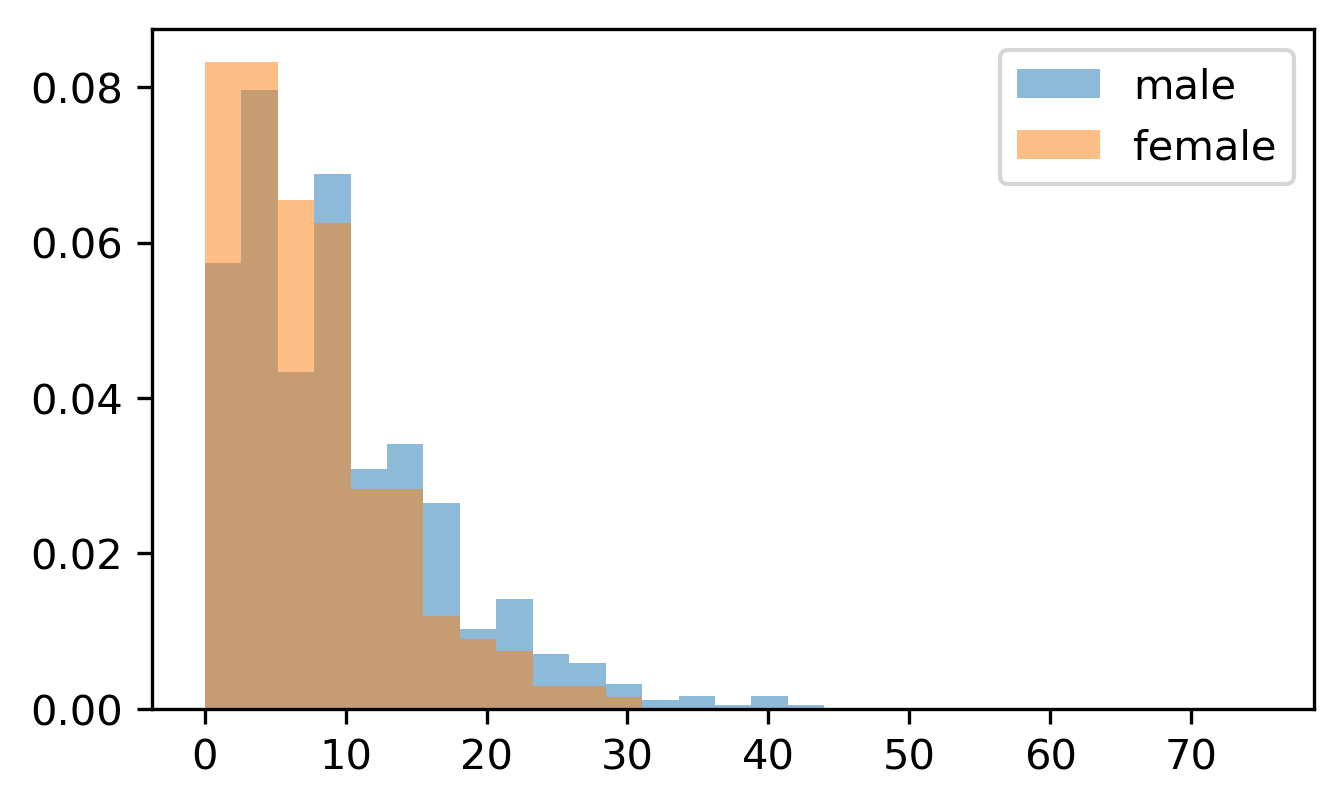

In [57]:
# https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart-with-matplotlib
bins = np.linspace(0,75,30)
plt.hist(m_test, bins, density=True,  alpha=0.5, label = "male")
plt.hist(f_test, bins, density=True, alpha=0.5, label = "female")
plt.legend(loc='upper right')
plt.show()

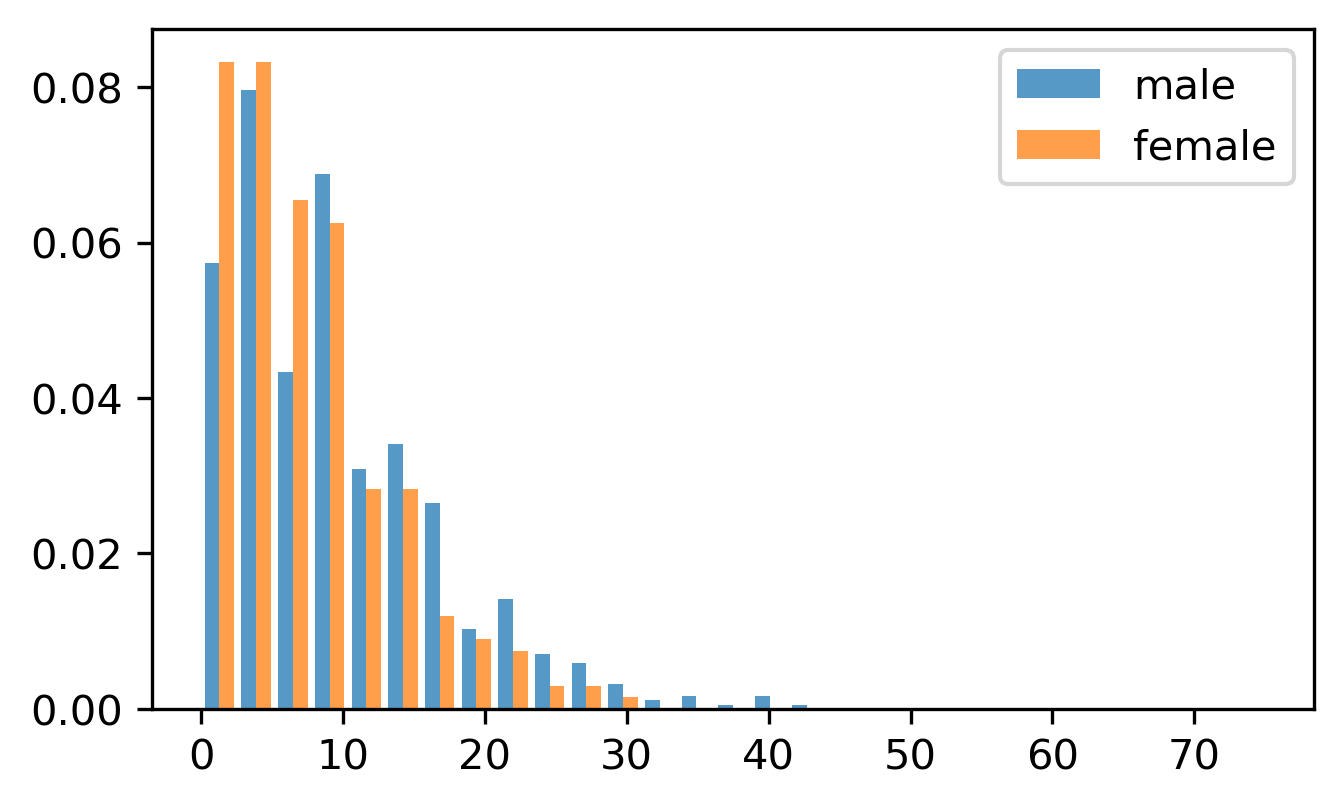

In [58]:
plt.hist([m_test,f_test], bins, density=True, alpha=0.75, label=['male','female'])
plt.legend(loc='upper right')
plt.show()

In [19]:
raw_series = raw_df.sum()

In [20]:
raw_series.head()

00          4
000      1187
000th       6
01          3
02          2
dtype: int64

Another caveat from the `01-Terms.ipynb` notebook: 
> The rest of the hand-examination turns up no other issues, so the basic vectorization built into `sklearn` appears to be satisfactory, with the only exception being its breaking of contractions at the apostrophe: e.g., *isn't* becomes *isn* and *'t*, with the latter being thrown away as too small -- which means that the indefinite article *a(n)* is also not present in the frequencies, but the definite article *the* remains. 

## Remove the non-words:

In [59]:
trunc_df = raw_df.iloc[:,414:]
trunc_df.shape

(992, 22019)

In [60]:
raw_df.shape[1] - trunc_df.shape[1]

414

In [61]:
# How many talks does each word appear in?
talks_per_word = (trunc_df > 0).sum(axis = 0)

In [62]:
max(talks_per_word)

985

In [63]:
male_tdf = trunc_df.iloc[:714,:]
male_tdf.shape

(714, 22019)

In [64]:
female_tdf = trunc_df.iloc[714:(714+260),:]
female_tdf.shape

(260, 22019)

In [65]:
nog_tdf = trunc_df.iloc[-8:,:]
nog_tdf.shape

(8, 22019)

In [66]:
# How many times does each word appear across the whole corpus of male talks? 
count_per_word_m = male_tdf.sum(axis = 0)

# How many talks does each word appear in?
talks_per_word_m = (male_tdf > 0).sum(axis = 0)

# How many words are in each talk? 
words_in_talk_m = male_tdf.sum(axis = 1)

# How many unique words per talk? 
unique_words_talk_m = (male_tdf > 0).sum(axis = 1)

In [67]:
print('Smallest number of times a word is used is',count_per_word_m.min() ,
      'while the largest number of times is',count_per_word_m.max())
print('The average number of times a word is used is',round(count_per_word_m.mean(),2) ,
      'with a standard deviation of',round(count_per_word_m.std(),2),
      '\n The median is', count_per_word_m.median() )

Smallest number of times a word is used is 0 while the largest number of times is 70994
The average number of times a word is used is 63.54 with a standard deviation of 896.15 
 The median is 5.0


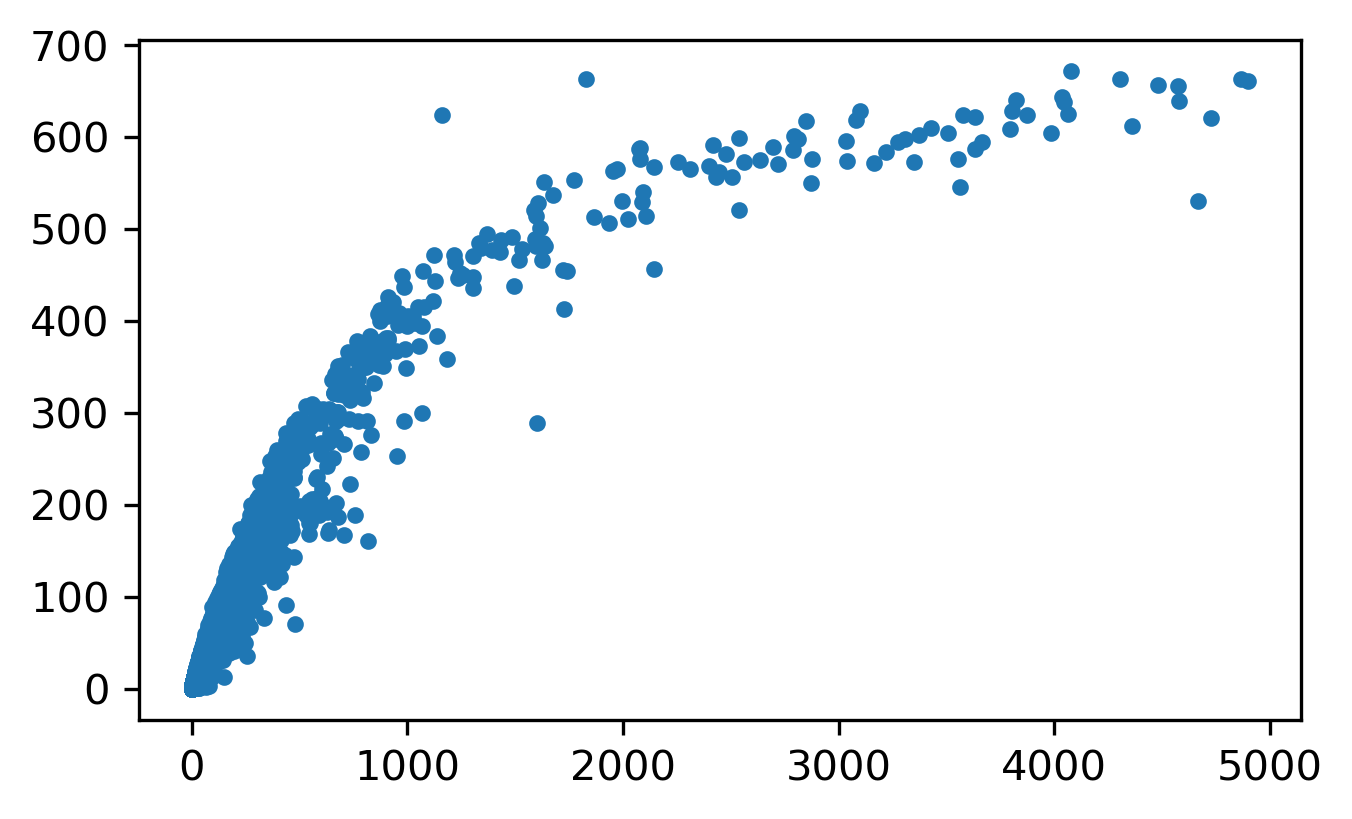

In [68]:
inds = count_per_word_m < 5000

plt.plot(count_per_word_m[inds],talks_per_word_m[inds],".")

In [69]:
# How many times does each word appear across the whole corpus of female talks? 
count_per_word_f = female_tdf.sum(axis = 0)

# How many talks does each word appear in?
talks_per_word_f = (female_tdf > 0).sum(axis = 0)

# How many words are in each talk? 
words_in_talk_f = female_tdf.sum(axis = 1)

# How many unique words per talk? 
unique_words_talk_f = (female_tdf > 0).sum(axis = 1)

In [70]:
print('Smallest number of times a word is used is',count_per_word_f.min() ,
      'while the largest number of times is',count_per_word_f.max())
print('The average number of times a word is used is',round(count_per_word_f.mean(),2) ,
      'with a standard deviation of',round(count_per_word_f.std(),2),
      '\n The median is', count_per_word_f.median() )

Smallest number of times a word is used is 0 while the largest number of times is 21794
The average number of times a word is used is 21.31 with a standard deviation of 291.93 
 The median is 2.0


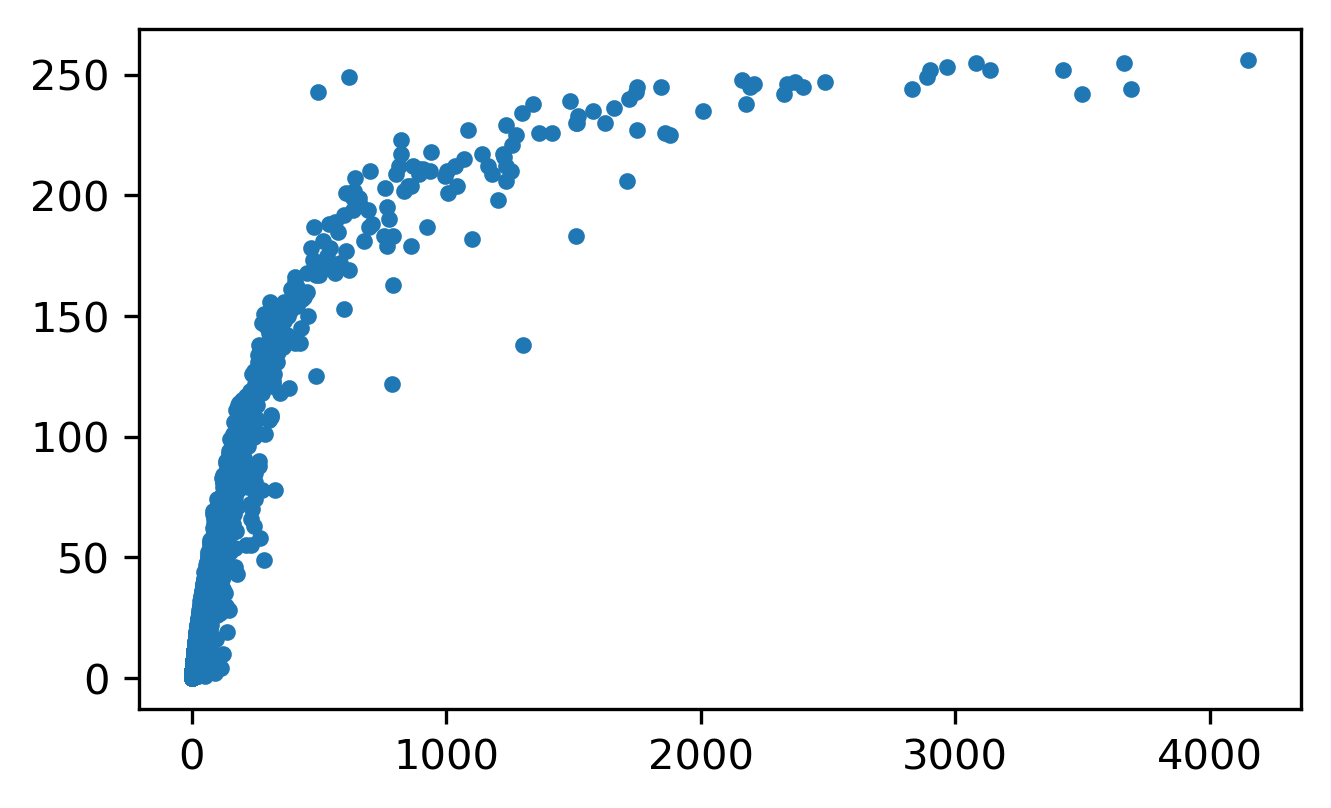

In [71]:
inds = count_per_word_f < 5000

plt.plot(count_per_word_f[inds],talks_per_word_f[inds],".")

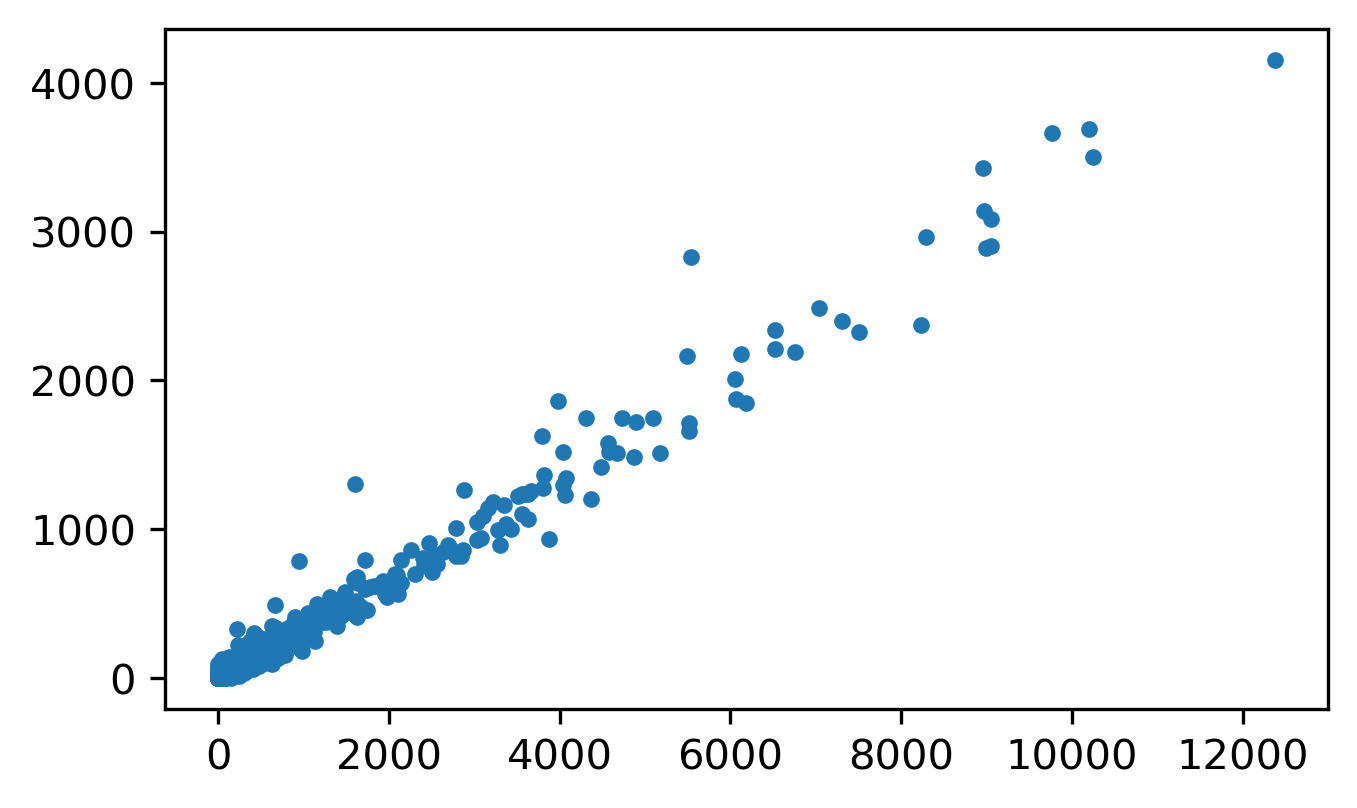

In [72]:
plt.plot(count_per_word_m[inds],count_per_word_f[inds],".")

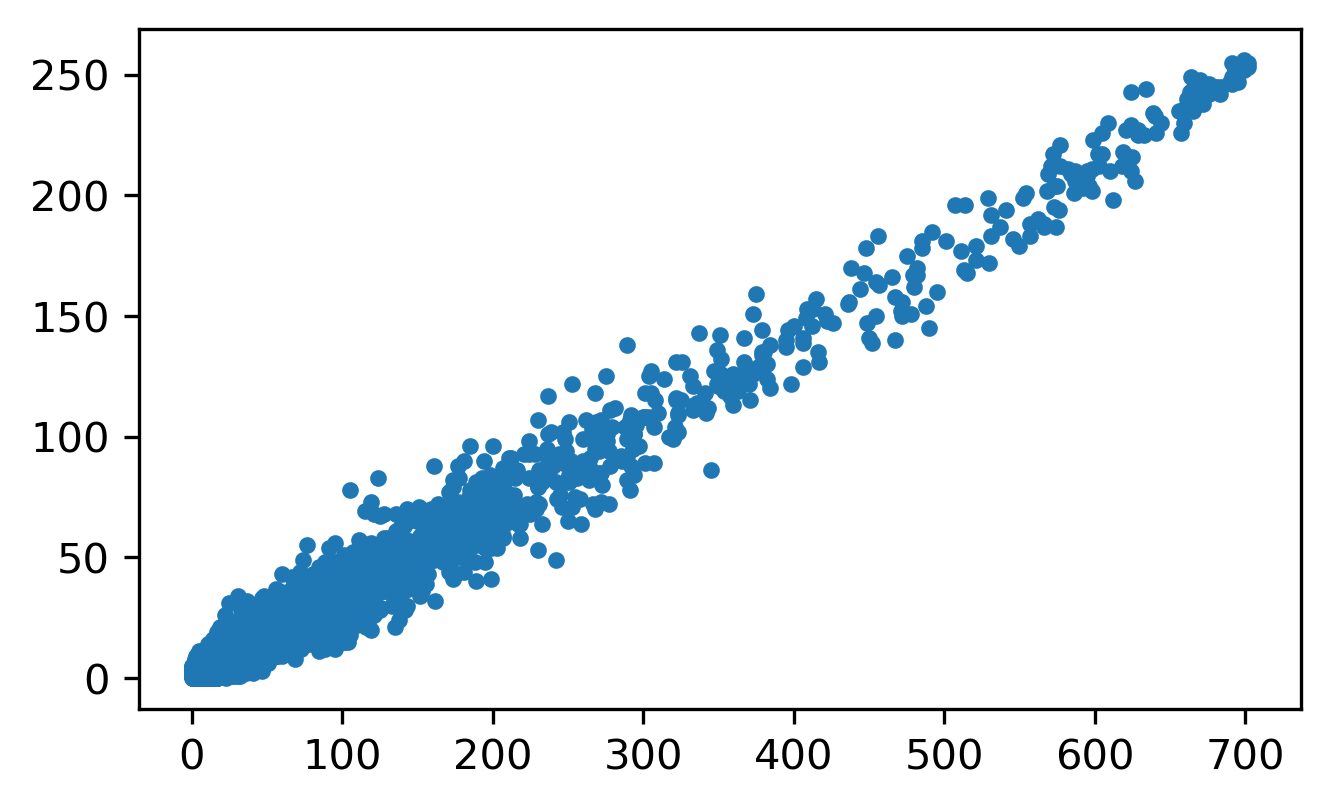

In [73]:
plt.plot(talks_per_word_m[inds],talks_per_word_f[inds],".")

In [74]:
# How many times does each word appear across the whole corpus of female talks? 
count_per_word_n = nog_tdf.sum(axis = 0)

# How many talks does each word appear in?
talks_per_word_n = (nog_tdf > 0).sum(axis = 0)

# How many words are in each talk? 
words_in_talk_n = nog_tdf.sum(axis = 1)

# How many unique words per talk? 
unique_words_talk_n = (nog_tdf > 0).sum(axis = 1)

In [75]:
print('Smallest number of times a word is used is',count_per_word_n.min() ,
      'while the largest number of times is',count_per_word_n.max())
print('The average number of times a word is used is',round(count_per_word_n.mean(),2) ,
      'with a standard deviation of',round(count_per_word_n.std(),2),
      '\n The median is', count_per_word_n.median() )

Smallest number of times a word is used is 0 while the largest number of times is 608
The average number of times a word is used is 0.63 with a standard deviation of 8.51 
 The median is 0.0


## Either Male or Female words that are never used


In [76]:
minds_low = count_per_word_m <= 10
finds_low = count_per_word_f <= 10

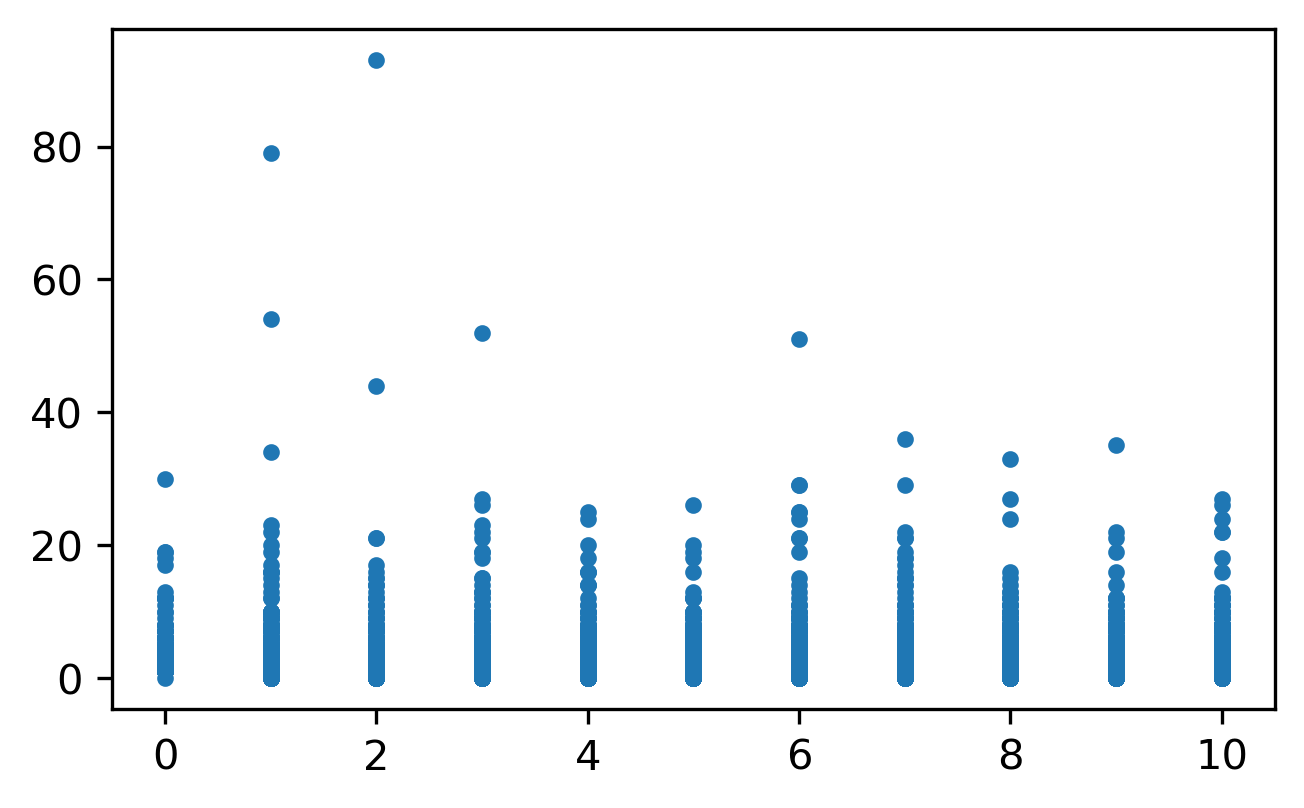

In [77]:
plt.plot(count_per_word_m[minds_low],count_per_word_f[minds_low],".")

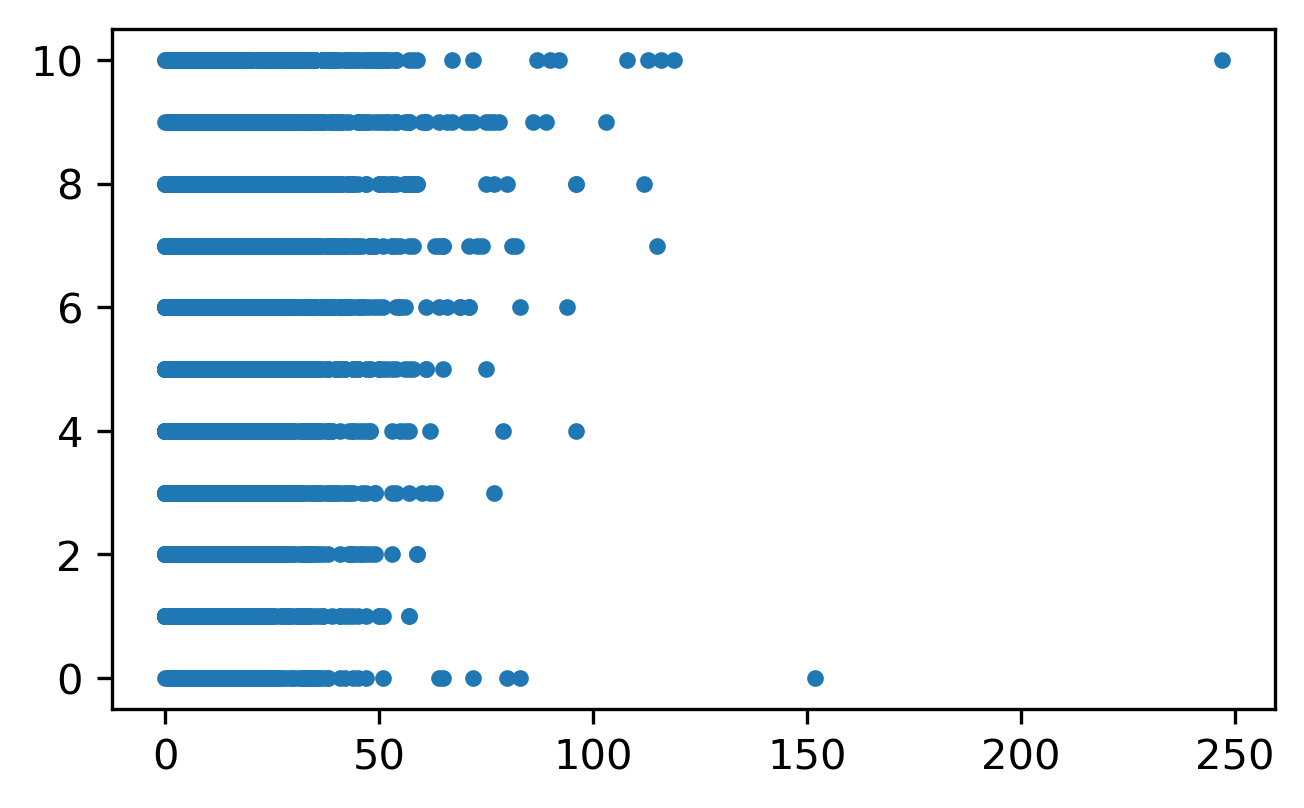

In [78]:
plt.plot(count_per_word_m[finds_low],count_per_word_f[finds_low],".")

In [79]:
finds = (count_per_word_m <= 10) & (count_per_word_f > 20) #High F count, low M count
minds = (count_per_word_m > 50) & (count_per_word_f <= 10) #High M count, low F count

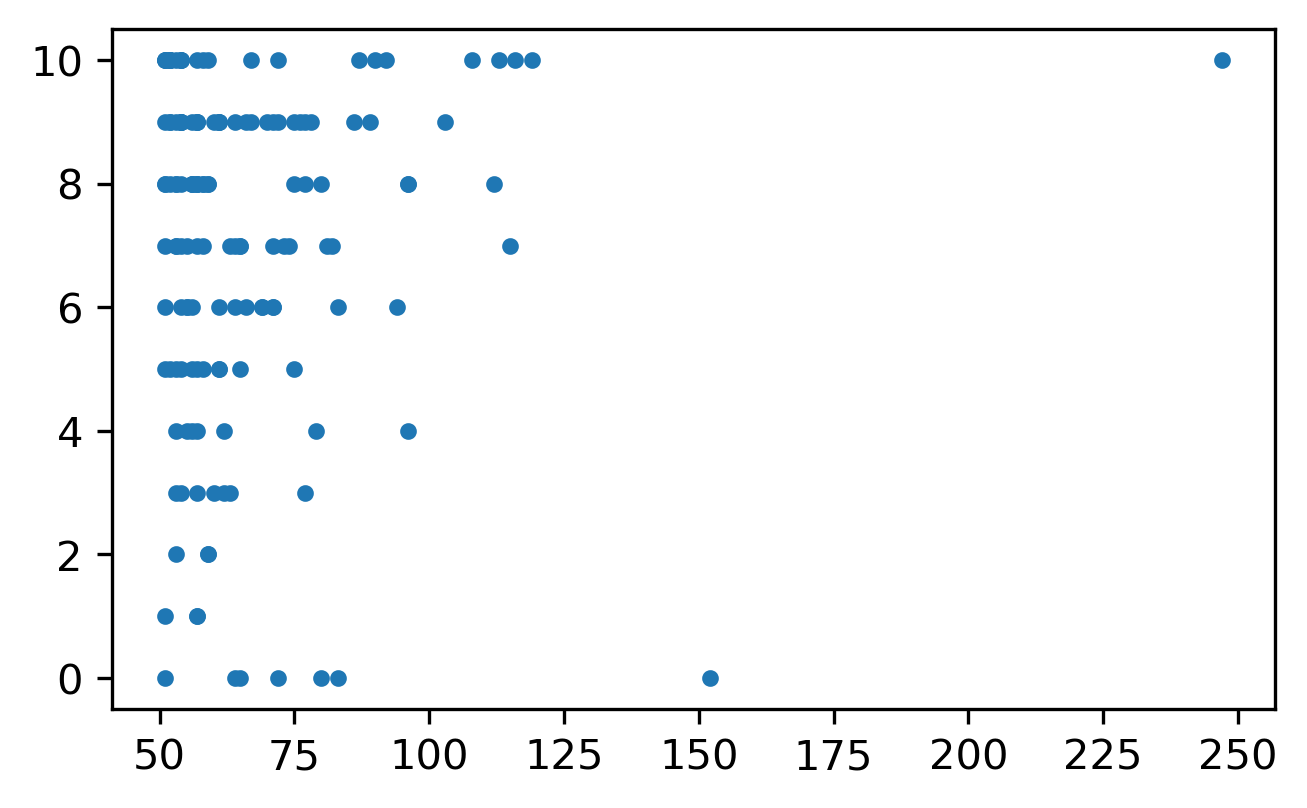

In [80]:
plt.plot(count_per_word_m[minds],count_per_word_f[minds],".")

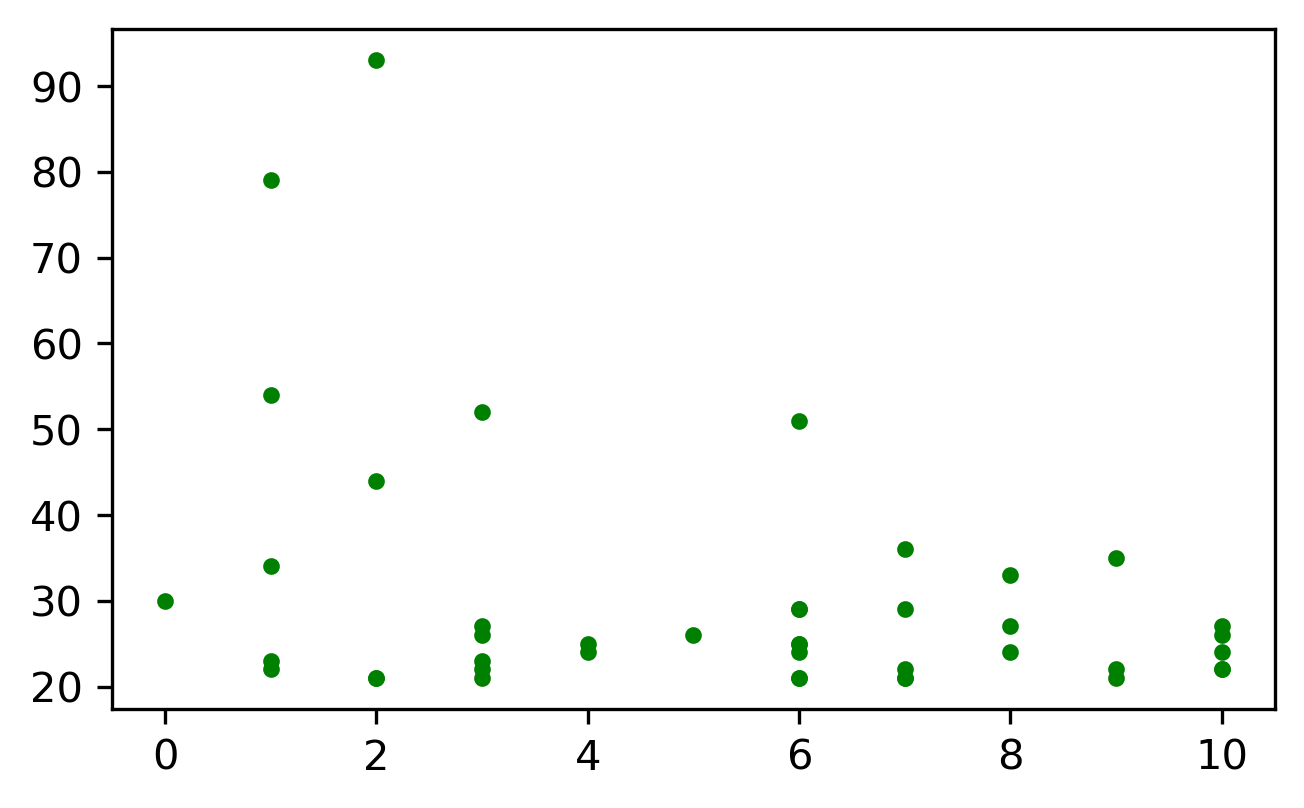

In [81]:
plt.plot(count_per_word_m[finds],count_per_word_f[finds],"g.")

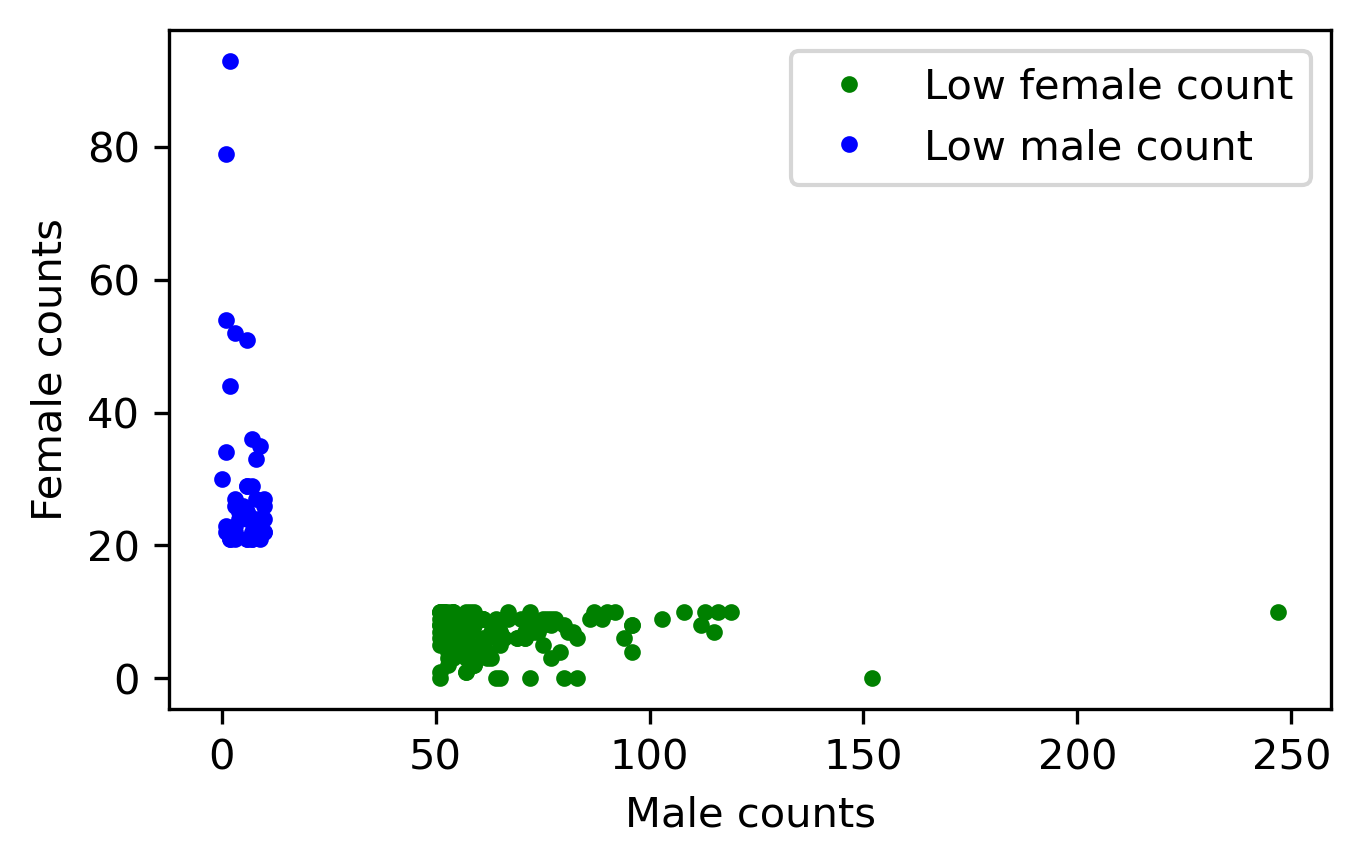

In [82]:
plt.plot(count_per_word_m[minds],count_per_word_f[minds], "g.", label = "Low female count")
plt.plot(count_per_word_m[finds],count_per_word_f[finds], "b.", label = "Low male count")

plt.xlabel('Male counts')
plt.ylabel('Female counts')
plt.legend(loc='upper right')

plt.show()

# https://matplotlib.org/stable/gallery/pyplots/pyplot_simple.html

In [45]:
# Words with high counts in female talks that have a low count in male talks
finds[finds].index

Index(['affair', 'africans', 'bamboo', 'bonobo', 'bronx', 'chuck', 'clams',
       'colonies', 'cs', 'dictionaries', 'dolphin', 'epic', 'females',
       'fireflies', 'gamers', 'gaza', 'glamorous', 'glamour', 'hackers', 'hum',
       'infections', 'jellyfish', 'kepler', 'li', 'looting', 'maintenance',
       'mating', 'orgasm', 'philanthropy', 'prevalence', 'reefs', 'sarah',
       'skeletal', 'squid', 'sr', 'strike', 'sw', 'taliban', 'titan',
       'trafficking', 'ultraviolet', 'vagina', 'vulnerability'],
      dtype='object')

In [46]:
count_per_word_f

900             6
90s            11
91              1
911             0
92              1
               ..
zooplankton     0
zoos            1
zuckerberg      2
zulu            0
zurich          2
Length: 22036, dtype: int64

In [47]:
#Words with high counts in male talks that have a low count in female talks
list(minds[minds].index)

['anger',
 'apple',
 'argument',
 'automatically',
 'axis',
 'balloon',
 'battery',
 'bottle',
 'burn',
 'capability',
 'charles',
 'chicken',
 'classes',
 'clock',
 'comet',
 'components',
 'computing',
 'conscious',
 'controlled',
 'cortex',
 'crash',
 'creature',
 'dan',
 'debate',
 'defense',
 'designs',
 'detect',
 'dh',
 'dimensional',
 'dimensions',
 'dinosaurs',
 'directions',
 'disaster',
 'discussion',
 'dollar',
 'dots',
 'driver',
 'ed',
 'efficiency',
 'electric',
 'em',
 'emissions',
 'engine',
 'error',
 'existing',
 'explanation',
 'exponential',
 'fake',
 'falling',
 'features',
 'feedback',
 'finger',
 'fold',
 'francisco',
 'fund',
 'furniture',
 'fusion',
 'gang',
 'gentlemen',
 'gray',
 'grid',
 'gun',
 'hardware',
 'hollywood',
 'ii',
 'infinite',
 'infrastructure',
 'input',
 'interface',
 'internal',
 'invent',
 'kb',
 'ladies',
 'laser',
 'lets',
 'link',
 'logic',
 'manufacturing',
 'maps',
 'mechanical',
 'metaphor',
 'mile',
 'mit',
 'moore',
 'mouse',
 'ms'

In [48]:
test_index = ["female word counts", "female talk numbers","male word counts", "male talk numbers"]


In [49]:
test = pd.DataFrame([count_per_word_f, talks_per_word_f,
                     count_per_word_m, talks_per_word_m], index = test_index).T

# https://stackoverflow.com/questions/19851005/rename-pandas-dataframe-index
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html

In [50]:

test 


,female word counts,female talk numbers,male word counts,male talk numbers
900,6,6,20,19
90s,11,8,25,25
91,1,1,7,4
911,0,0,6,4
92,1,1,9,8
...,...,...,...,...
zooplankton,0,0,4,3
zoos,1,1,2,2
zuckerberg,2,2,3,2
zulu,0,0,2,2


In [51]:
count_index = ["female word counts", "male word counts"]

In [52]:
fm_counts = pd.DataFrame([count_per_word_f, count_per_word_m], index = count_index).T

# https://stackoverflow.com/questions/19851005/rename-pandas-dataframe-index
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html

In [53]:
fm_counts

,female word counts,male word counts
900,6,20
90s,11,25
91,1,7
911,0,6
92,1,9
...,...,...
zooplankton,0,4
zoos,1,2
zuckerberg,2,3
zulu,0,2


## Topics (NMF)

In [54]:
k = 50
model = NMF( init="nndsvd", n_components= k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform(X.toarray())
H = model.components_

NameError: name 'NMF' is not defined

In [ ]:
W.shape, H.shape


In [ ]:
W

In [ ]:
H

In [ ]:
# Topic-word matrix: 

tw_df = pd.DataFrame(H, columns = vectorizer.get_feature_names_out())
tw_df.shape

In [ ]:
tw_trunc = tw_df.iloc[:,789:]
tw_trunc.shape

In [ ]:
tw_trunc

In [ ]:
#tw_trunc.columns.values[np.argsort(-tw_trunc.values,axis = 1)[:,:20]]

# From here: https://stackoverflow.com/questions/54923349/top-3-values-per-row-in-pandas


### Feb 8 - notes

Clear that stopwords have not been removed. Based on counts, should be easy to remove. Ideas for removing words:

* words that appear in every talk  
* words that are on the stopword list

In [ ]:
np.ones([2,3])

In [ ]:
# Create a topic-word matrix that places a 1 where there are 
tw_trunc_bin = (tw_trunc>0).to_numpy()*np.ones([50,38325])

# Count the number of words in each topic
tw_trunc_bin.sum(axis = 1)

In [ ]:
print("Average number of words per column is:", tw_trunc_bin.sum(axis = 1).mean(), 
      "with a standard deviation of:", round(tw_trunc_bin.sum(axis = 1).std(),2))

In [ ]:
tw_trunc_bin.shape[1]/50


In [ ]:
topics_per_word = tw_trunc_bin.sum(axis = 0)

In [ ]:
max(topics_per_word)

In [ ]:
min(topics_per_word)

In [ ]:
np.mean(topics_per_word)

In [ ]:
plt.hist(topics_per_word)
plt.show()

In [ ]:
(tw_trunc).sum(axis = 1)

In [ ]:
fm_topic_counts = np.matmul(tw_trunc.to_numpy(),fm_counts.to_numpy())

In [ ]:
plt.plot(fm_topic_counts[:,0], fm_topic_counts[:,1],"*")
plt.show()


In [ ]:
fm_topic_counts_bin = np.matmul(tw_trunc_bin,fm_counts.to_numpy())

In [ ]:
plt.plot(fm_topic_counts_bin[:,0], fm_topic_counts_bin[:,1],"*")
plt.show()

## Either Male or Female words that are never used in talks



In [ ]:
mtnds_low = talks_per_word_m <= 10
ftnds_low = talks_per_word_f <= 10

## Revised Frequencies without Parentheticals

For more on the work leading up to this regex, see the `01-Terms-02-Parentheticals` notebook: it contains a number of experiments, which were vexed by sklearn's vectorizer only accepting strings as inputs. (While gensim appears to accept texts as lists of words, we are hoping, I think, to keep our code base as simple as possible.) The eventual workaround is to clean the texts of the top 20 parentheticals, joining the list back to a string, and then pushing the result to sklearn. This is less than optimum, but the hack works and appears to be a hack performed elsewhere by others.

For now, the first thing we have is the list of the top 20 parentheticals, some of which are two words:

In [ ]:
noparens_vec = CountVectorizer(preprocessor = remove_parentheticals)
noparens_X = noparens_vec.fit_transform(texts)
noparens_X.shape

Good news. Our removal parentheticals has only removed two words. 

In [ ]:
noparens_df = pd.DataFrame(noparens_X.toarray(), columns = noparens_vec.get_feature_names())

In [ ]:
term = 'laughter'
f"The baseline count for *{term}* is {raw_df[term].sum()}; \
with cleaning it is {noparens_df[term].sum()}"

## Frequencies of Terms with a 2-Document Minimum

Setting a `min_df = 2` removes all words that appear in only document. (An exploration of *one document wonders* is elsewhere.) As we can see from the `shape` below, we dropped 50379 to 29340, resulting in a reduction of 42% of the possible features.

In [ ]:
min2_vec = CountVectorizer(preprocessor = remove_parentheticals, min_df = 2)
min2_X = min2_vec.fit_transform(texts)
min2_X.shape

As above we can sum our terms and write the results to a CSV file for closer inspection. Here, we highlight just a particular series of words.

In [ ]:
# Create the dataframe
min2_df = pd.DataFrame(min2_X.toarray(), columns = min2_vec.get_feature_names())

# Create a series of sums
min2_series = min2_df.sum()

# Write sums to CSV:
# min2_series.to_csv('../output/word_freq_clean.csv')

# Inspect the sums
min2_series[1000:1005]

## Frequencies of Terms Appearing in All Documents

Having trimmed terms that occur in only document from our feature set, we also need to determine what words occur across all the documents and thus are not particularly effective discriminators of topic. 

Note that this is a somewhat more dangerous move to make, since it has been shown that one of the keys to genre and gender in documents are the varying uses of so-called function words. In fact, as our explorations establish, using sklearn's built-in algorithms reveals a focus on removing common words does not really result in much of a reduction in the overall feature set, only 8 words occurring across 99% or more documents and that number only rising to 46 when we change the minimum threshold to 90%.

In [ ]:
alldocs_vec = CountVectorizer(preprocessor = remove_parentheticals, min_df = 0.99)
alldocs_X = alldocs_vec.fit_transform(texts)
alldocs_X.shape

In [ ]:
alldocs_df = pd.DataFrame(alldocs_X.toarray(), columns = alldocs_vec.get_feature_names())
alldocs_series = alldocs_df.sum()
alldocs_series

In [ ]:
mostdocs_vec = CountVectorizer(preprocessor = remove_parentheticals, min_df = 0.90)
mostdocs_X = mostdocs_vec.fit_transform(texts)
mostdocs_X.shape

In [ ]:
# mostdocs_df = pd.DataFrame(mostdocs_X.toarray(), columns = mostdocs_vec.get_feature_names())
# mostdocs_series = mostdocs_df.sum()
# mostdocs_series.head(46)

This last run simply verifies that the exploration above with `min_df` holds true when we switch to `max_df`. That is, that our exploration of the parameters were not asking something unexpected by the code and possibly generating inexplicable and undesirable results.

In [ ]:
# tnt = topsntails
tnt_vec = CountVectorizer(preprocessor = remove_parentheticals, max_df = 0.9, min_df = 2)
tnt_X = tnt_vec.fit_transform(texts)
tnt_X.shape

The numbers add up. With that done, my recommendation is that we do not, for the time being, throw away common and/or function words: that is, let's not use a stopword list. Those words could be important in other ways, and dropping them has only a limited impact on the actual document-term matrix, one that pales by comparison to the words that occur only in one document.